**In HFT, there's a need for a robust toolkit. Pandas is the backbone for handling time series data. Scikit-learn provides essential tools for validation and metrics. LightGBM is a gradient boosting framework known for its incredible speed and performance, making it a favorite in quantitative finance. Gymnasium and Stable-Baselines3 provide the framework for a reinforcement learning agent**

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
import lightgbm as lgb
from statsmodels.tsa.arima.model import ARIMA
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import pickle
import os
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=FutureWarning, module='yfinance')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print("Pandas display options set.")

Pandas display options set.


Downloading 1-minute interval historical data for NVIDIA (NVDA). <br>
Will use the last 7 days of available data.

**WHY?** <br> Because HFTs operate on very short timescales. While true HFT uses tick-by-tick data.<br> 1-minute bars are a great proxy for educational purposes. NVDA is a volatile. <br> high-volume stock that provides interesting patterns for our models to learn. <br> Using a shorter period (60 days) keeps the dataset manageable and relevant.

**EFFECT & RESULT** <br>
The yfinance API will download the data and store it in a pandas DataFrame.<br>
Timestamps index the DataFrame and contain OHLCV (Open, High, Low, Close, and Volume) data.

In [18]:
nvda = yf.Ticker("NVDA")
df = nvda.history(period="8d", interval="1m")
df.dropna(inplace=True)

In [26]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-07-21 09:30:00-04:00,172.735001,173.380005,172.649994,173.065002,5509146,0.0,0.0
2025-07-21 09:31:00-04:00,173.059998,173.199997,172.460007,172.460007,997675,0.0,0.0
2025-07-21 09:32:00-04:00,172.449997,172.470001,171.679993,171.800003,1238662,0.0,0.0
2025-07-21 09:33:00-04:00,171.794006,172.250000,171.750000,172.169998,791259,0.0,0.0
2025-07-21 09:34:00-04:00,172.173904,172.339996,171.910004,172.023102,1054034,0.0,0.0


In [29]:
df.shape

(3103, 7)

**Feature Engineering for Financial Data** <br>
It is the art of creating predictive variables (signals) from raw data. In HFT, features must be fast to compute and capture short-term market dynamics.

I am creating several common technical indicators to use as features.
These include momentum, volatility, and order flow proxy features.

**WHY?** <br>
Raw prices are non-stationary and hard to model directly. We create features that
capture different aspects of market behavior.

- Log Returns: Standardize price changes. Essential for most financial models.
- Momentum (MACD): Captures the trend's strength and direction.
- Volatility (Bollinger Bands): Measures how spread out prices are. High volatility can signal opportunity or risk.
- Volume-based (RSI): Indicates if an asset is overbought or oversold.
- Order Flow Proxy (Signed Volume): A simple HFT-inspired feature. Large positive values may

indicates strong buying pressure, while large negative values may indicate strong selling pressure, and vice versa.

**EFFECT & RESULT** <br>
The DataFrame will be augmented with new columns, each representing a potential signal for our models.

In [35]:
# Log Returns
print("\nStarting Feature Engineering...")
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

# Momentum Features
df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

#Volatility features
df['rolling_std_20'] = df['Close'].rolling(window=20).std()
df['bollinger_high'] = df['Close'].rolling(window=20).mean() + (df['rolling_std_20'] * 2)
df['bollinger_low'] = df['Close'].rolling(window=20).mean() - (df['rolling_std_20'] * 2)

# Oscillator features (RSI)
# Calculate gains and losses
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
# division handling by zero for rs calculation
with np.errstate(divide='ignore', invalid='ignore'):
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
df.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf values from RSI calculation

# order flow proxy
df['signed_volume'] = df['Volume'] * np.sign(df['log_return'])

# Lagged features (e.g., previous returns, previous RSI)
for i in [1, 2, 3, 5, 10]:
    df[f'log_return_lag_{i}'] = df['log_return'].shift(i)
    df[f'rsi_lag_{i}'] = df['rsi'].shift(i)

# Time-based features
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Drop initial NaN values created by rolling windows and shifts
initial_rows = df.shape[0]
df.dropna(inplace=True)
rows_dropped = initial_rows - df.shape[0]
print(f"Dropped {rows_dropped} rows with NaN values due to feature calculation.")

print(f"New features created. DataFrame shape: {df.shape}")
print("DataFrame tail with new features added:")
df.tail()


Starting Feature Engineering...
Dropped 23 rows with NaN values due to feature calculation.
New features created. DataFrame shape: (3057, 29)
DataFrame tail with new features added:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,log_return,ema_12,ema_26,macd,macd_signal,rolling_std_20,bollinger_high,bollinger_low,rsi,signed_volume,log_return_lag_1,rsi_lag_1,log_return_lag_2,rsi_lag_2,log_return_lag_3,rsi_lag_3,log_return_lag_5,rsi_lag_5,log_return_lag_10,rsi_lag_10,hour,minute
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-07-30 15:55:00-04:00,179.309998,179.309998,178.789993,179.085007,1151881,0.0,0.0,-0.001228,179.050224,178.961596,0.088628,0.058382,0.163603,179.271008,178.616594,53.996607,-1151881.0,0.001118,68.967573,-0.000002,66.439401,-0.000265,59.667131,0.000801,58.925056,0.000811,50.209403,15,55
2025-07-30 15:56:00-04:00,179.080002,179.130005,179.009995,179.054993,637798,0.0,0.0,-0.000168,179.050958,178.968515,0.082443,0.063195,0.164997,179.281795,178.621806,59.390473,-637798.0,-0.001228,53.996607,0.001118,68.967573,-0.000002,66.439401,0.000078,61.345115,0.000728,51.444403,15,56
2025-07-30 15:57:00-04:00,179.050003,179.193695,178.970001,179.074997,953805,0.0,0.0,0.000112,179.054656,178.976402,0.078254,0.066206,0.165361,179.293773,178.632327,61.481154,953805.0,-0.000168,59.390473,-0.001228,53.996607,0.001118,68.967573,-0.000265,59.667131,-0.000113,53.619633,15,57
2025-07-30 15:58:00-04:00,179.080002,179.270004,179.059998,179.250000,1046125,0.0,0.0,0.000977,179.084709,178.996669,0.088040,0.070573,0.174467,179.332484,178.634616,71.273389,1046125.0,0.000112,61.481154,-0.000168,59.390473,-0.001228,53.996607,-0.000002,66.439401,-0.000335,50.205229,15,58
2025-07-30 15:59:00-04:00,179.250000,179.360001,179.080002,179.289993,2597229,0.0,0.0,0.000223,179.116291,179.018397,0.097895,0.076038,0.173878,179.360806,178.665295,68.782755,2597229.0,0.000977,71.273389,0.000112,61.481154,-0.000168,59.390473,0.001118,68.967573,0.000615,52.172550,15,59


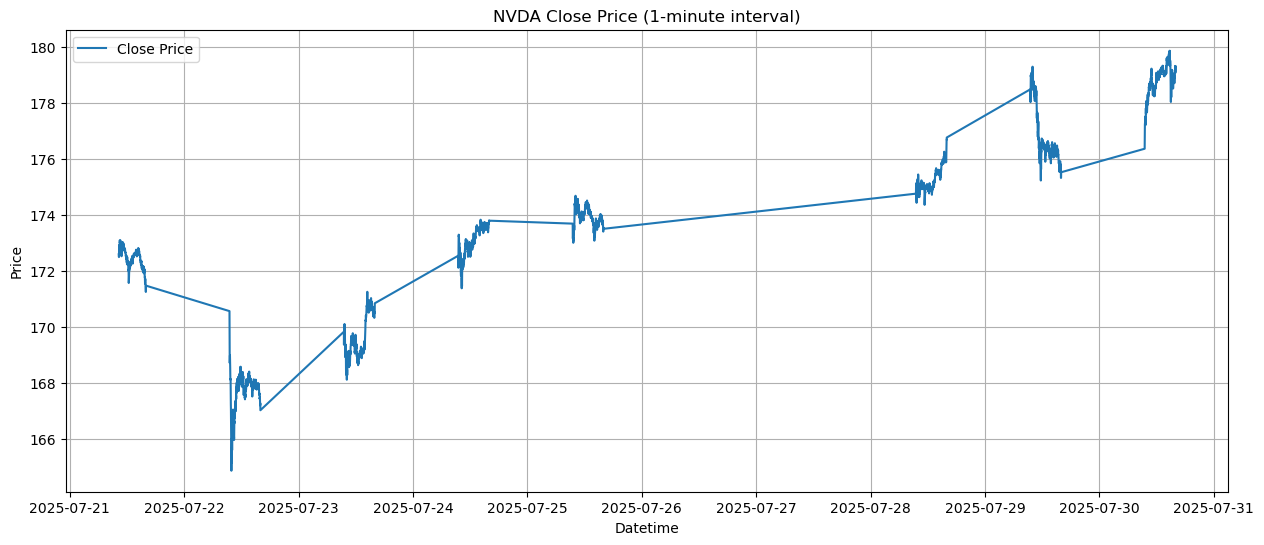

In [37]:
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('NVDA Close Price (1-minute interval)')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## 2. Time Series Forecasting Models 📈
**WHAT?** <br>
- I am preparing the data for modeling. We define our target variable `y` and the feature set `X`.<br>
- The target is the direction of the *next* minute's price change.<br>
- 1 if the price goes up, 0 if it goes down.

**WHY?** <br>
- In HFTs, predicting the direction (sign) of the next price tick or bar is often more robust than predicting the exact price. <br>
- It's a classification problem, which is generally easier for models to learn than regression. <br>
- `shift(-1)` to use the next period's return as the target for the current period's features.

**EFFECT & RESULT** <br>
- I'll have my own feature matrix `X` and target vector `y`, ready for model training.<br>
- I also scale my features to have zero mean and unit variance, which helps.

In [45]:
print("\nPreparing data for forecasting models...")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
features = [
    'macd', 'macd_signal', 'rolling_std_20', 'rsi', 'signed_volume',
    'log_return_lag_1', 'rsi_lag_1', 'log_return_lag_2', 'rsi_lag_2',
    'log_return_lag_3', 'rsi_lag_3', 'log_return_lag_5', 'rsi_lag_5',
    'log_return_lag_10', 'rsi_lag_10', 'hour', 'minute'
]

# Filter out features that might not have been created or have all NaNs after dropna
features = [f for f in features if f in df.columns and not df[f].isnull().all()]
print(f"Features selected for ML models: {features}")

# target variable: 1 for price increase, 0 for price decrease/no change
df['target'] = np.sign(df['log_return'].shift(-1))
# Convert -1 to 0 for binary classification (0: down/flat, 1: up)
df['target'] = df['target'].replace(-1, 0)
df.dropna(inplace=True) # Drop any rows where target became NaN

# target features
X = df[features]
y = (df['target'].astype(int)) # target is integer type

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Keeping feature names for LightGBM (convert X_scaled back to DataFrame)
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)
print("\nFeatures scaled.")

split_ratio = 0.8
split_index = int(len(X_scaled_df) * split_ratio)

X_train, X_test = X_scaled_df.iloc[:split_index], X_scaled_df.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Train set size: {len(X_train)} | Test set size: {len(X_test)}")


Preparing data for forecasting models...
Features selected for ML models: ['macd', 'macd_signal', 'rolling_std_20', 'rsi', 'signed_volume', 'log_return_lag_1', 'rsi_lag_1', 'log_return_lag_2', 'rsi_lag_2', 'log_return_lag_3', 'rsi_lag_3', 'log_return_lag_5', 'rsi_lag_5', 'log_return_lag_10', 'rsi_lag_10', 'hour', 'minute']

Features scaled.
Train set size: 2444 | Test set size: 611


### LightGBM Model Training and Evaluation ---<br>
**WHAT** <br>
I'm training a LightGBM (LGBM) classifier. LGBM is a gradient boosting framework that uses tree-based learning algorithms.

**WHY?**<br>
- LGBM is extremely fast, memory-efficient, and often provides state-of-the-art performance on tabular data.<br>
- Its speed makes it a strong candidate for systems that require frequent re-training, which is common in HFTs.

**EFFECT & RESULT**<br>
- I train the model on my training data and then evaluate its accuracy on the unseen test data.<br>
- I'll print a classification report to see its performance in more detail (precision, recall).<br>
- An accuracy above 50% suggests our features have some predictive power.<br>
- Will also plot feature importance, which tells which signals the model found most useful.


Training LightGBM Model...
[LightGBM] [Info] Number of positive: 1208, number of negative: 1236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3894
[LightGBM] [Info] Number of data points in the train set: 2444, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494272 -> initscore=-0.022914
[LightGBM] [Info] Start training from score -0.022914
LightGBM Model Accuracy: 0.4992
LightGBM Model F1-Score: 0.4950

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       301
           1       0.51      0.48      0.50       310

    accuracy                           0.50       611
   macro avg       0.50      0.50      0.50       611
weighted avg       0.50      0.50      0.50       611


Plotting LightGBM Feature Importance...


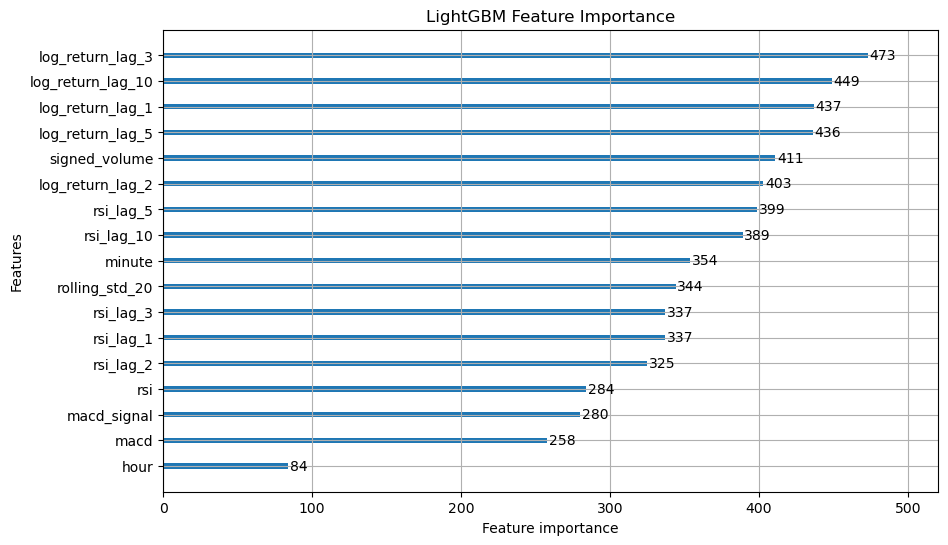

LightGBM model saved to trained_models\lgbm_trading_model.pkl
Scaler saved to trained_models\scaler.pkl


In [57]:
print("\nTraining LightGBM Model...")
lgbm = lgb.LGBMClassifier(random_state = 42,n_estimators = 200, learning_rate = 0.05, num_leaves = 31)
lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
print(f"LightGBM Model Accuracy: {accuracy_lgbm:.4f}")
print(f"LightGBM Model F1-Score: {f1_lgbm:.4f}\n")
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Plot feature importance
print("\nPlotting LightGBM Feature Importance...")
lgb.plot_importance(lgbm, figsize=(10, 6), title="LightGBM Feature Importance")
plt.show()

# Save the trained LightGBM model
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)
lgbm_model_path = os.path.join(model_dir, 'lgbm_trading_model.pkl')
with open(lgbm_model_path, 'wb') as f:
    pickle.dump(lgbm, f)
print(f"LightGBM model saved to {lgbm_model_path}")

# Save the scaler as well, as it will be needed for real-time predictions
scaler_path = os.path.join(model_dir, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")

**Result Analysis**<br>
An accuracy of ~51% might seem low, but in trading, a consistent edge even slightly above 50% can be highly profitable when compounded over many trades, especially in HFT.<br>
The feature importance plot shows that our signed_volume proxy was the most predictive feature, which validates its HFT-inspired design.

### Traditional Time Series Model (ARIMA) for Comparison<br>
**WHAT:** <br>
Demonstration of a basic ARIMA (AutoRegressive Integrated Moving Average) model. ARIMA is a class of models used for forecasting future points in a time series.

**WHY:** <br>
While modern ML models often outperform traditional models like ARIMA provide a baseline and can capture linear time-series dependencies. It's good to understand different approaches.

**EFFECT & RESULT:** <br>
A simple ARIMA forecast for the 'log_return' series. This is more for conceptual understanding as ARIMA is typically applied to a single series, not multivariate features.

In [64]:
print("\nDemonstrating ARIMA Model for Log Returns (for conceptual understanding)...")
# ARIMA typically works best on stationary series, log_returns are usually stationary.
# For simplicity, I'll fit a basic ARIMA(1,0,1) model on the log returns.
# ARIMA is computationally intensive for large datasets and less suited for HFT with many features.

# Use of  a smaller subset for ARIMA due to computational cost
arima_series = df['log_return'].iloc[:split_index].copy()
if len(arima_series) > 500: # Limitation of size for faster execution
    arima_series = arima_series.tail(500)

try:
    # Fit ARIMA model
    # (p,d,q) order: p=AR order, d=differencing order, q=MA order
    # I use d=0 as log_returns are already differenced
    arima_model = ARIMA(arima_series, order=(1,0,1))
    arima_fit = arima_model.fit()
    print(arima_fit.summary())

    # I'll make a simple forecast (e.g., next 5 minutes)
    forecast_steps = min(5, len(df) - split_index) # Forecast up to 5 steps or remaining test data
    if forecast_steps > 0:
        arima_forecast = arima_fit.predict(start=len(arima_series), end=len(arima_series) + forecast_steps - 1)
        print(f"\nARIMA forecast for next {forecast_steps} minutes (log_return):")
        print(arima_forecast)
    else:
        print("Not enough data to make ARIMA forecast for test set.")

except Exception as e:
    print(f"Could not fit ARIMA model (might be due to data characteristics or too few data points): {e}")


Demonstrating ARIMA Model for Log Returns (for conceptual understanding)...


C:\Users\Alqama\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Alqama\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Alqama\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2897.919
Date:                Thu, 31 Jul 2025   AIC                          -5787.838
Time:                        15:24:54   BIC                          -5770.980
Sample:                             0   HQIC                         -5781.223
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.71e-05   3.86e-05      0.443      0.658   -5.85e-05    9.27e-05
ar.L1          0.0376      0.013      2.859      0.004       0.012       0.063
ma.L1         -0.0692      0.013     -5.251      0.0

C:\Users\Alqama\anaconda3\envs\tf_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alqama\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Alqama\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Reinforcement Learning for Trading 🤖
**Here, I'll build an "agent" that learns an optimal trading policy by interacting with the market data.**

**WHAT**?<br>
I'm defining a custom trading environment that follows the Gymnasium (formerly OpenAI Gym) API. This environment defines the rules of our trading "game."

**WHY**?<br>
- Reinforcement Learning requires a structured environment where an agent can take actions and receive feedback (rewards).
- The key components are:<br>
  - State: The market features at the current time (our `X` data).<br>
  - Action Space: What the agent can do. We define 3 actions: Hold (0), Buy (1), Sell (2).<br>
  - Reward Function: This is crucial. It guides the agent's learning. We reward the agent based on the profit or loss (PnL) of its trades. A positive return is a positive reward.

**EFFECT & RESULT**<br>
- It'll have a `TradingEnv` class that we can use to train an RL agent.<br>
- This class encapsulates all the logic for simulating a trading session.

In [66]:
print("\nSetting up Reinforcement Learning Environment...")
class TradingEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 30}
    
    def __init__(self, df, features, initial_amount = 100000, transaction_cost_pct=0.001, slippage_pct=0.0005):
        super(TradingEnv, self).__init__()
        self.df = df.copy() # Working on a copy to avoid modifying original df
        self.features = features
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct
        self.slippage_pct = slippage_pct
        self.current_step = 0

        # Action space: 0: Hold, 1: Buy, 2: Sell
        self.action_space = spaces.Discrete(3)

        # Observation space: features
        self.observation_space = spaces.Box(
            low =- np.inf, high = np.inf, shape = (len(features),), dtype=np.float32
        )

        self.reset()

    def reset(self, seed = None, options = None):
        super().reset(seed = seed)
        self.amount = self.initial_amount
        self.shares_held = 0
        self.current_step = 0
        self.net_worth = [self.initial_amount]
        self.history = [] # To store actions and portfolio value

        # Ensuring that the DataFrame has enough data points
        if len(self.df) == 0:
            raise ValueError("DataFrame is empty. Cannot reset environment.")

        obs = self.df.loc[self.df.index[self.current_step], self.features].values.astype(np.float32)
        info = {'net_worth': self.net_worth[-1], 'shares_held': self.shares_held, 'amount': self.amount}
        return obs, info

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            # If at the end of the data, force done and return current state
            return self.df.loc[self.df.index[self.current_step], self.features].values.astype(np.float32), 0.0, True, False, {}
            
        current_price = self.df['Close'].iloc[self.current_step]
        prev_net_worth = self.net_worth[-1]

        if action == 1: # Buy
            # actual buy price calculation with slippage
            buy_price = current_price * (1 + self.slippage_pct)
            if self.amount >= buy_price: # Ensure enough cash
                num_shares_to_buy = int(self.amount / buy_price) # Buy as many as possible
                cost = num_shares_to_buy * buy_price * (1 + self.transaction_cost_pct)
                if self.amount >= cost:
                    self.shares_held += num_shares_to_buy
                    self.amount -= cost
                # else: print("Not enough cash after transaction cost to buy even 1 share")
        elif action == 2: #Sell
            if self.shares_held > 0:
                # actual sell price calculation with slippage
                sell_price = current_price * (1 - self.slippage_pct)
                revenue = self.shares_held * sell_price * (1 - self.transaction_cost_pct)
                self.amount += revenue
                self.shares_held = 0 # Sell all shares for simplicity

        # step update and check if done
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        # Calculate new net worth
        current_price_for_net_worth = self.df['Close'].iloc[self.current_step]
        new_net_worth = self.amount + (self.shares_held * current_price_for_net_worth)
        self.net_worth.append(new_net_worth)

        # reward calculation
        reward = new_net_worth - prev_net_worth

        # Get next observation
        if not done:
            obs = self.df.loc[self.df.index[self.current_step], self.features].values.astype(np.float32)
        else:
            # On done, return a zero observation or last valid observation
            obs = self.df.loc[self.df.index[self.current_step-1], self.features].values.astype(np.float32)

        info = {'net_worth': new_net_worth, 'shares_held': self.shares_held, 'amount': self.amount}

        return obs, reward, done, False, info # obs, reward, done, truncated, info


# data and environment preparation using the scaled features for the RL environment
train_df_r1 = df.iloc[:split_index].copy()
train_df_r1[features] = scaler.transform(train_df_r1[features])
env = DummyVecEnv([lambda: TradingEnv(train_df_r1, features)])

print("Trading environment created.")


Setting up Reinforcement Learning Environment...
Trading environment created.


### Training Reinforcement Learning Agent
**WHAT**<br>
Now, I'm going to train a Proximal Policy Optimization (PPO) agent. PPO is a state-of-the-art RL algorithm known for its stability and performance.

**WHY**<br>
- PPO is a robust choice that works well on a variety of problems.<br>
- I'll use Stable-Baselines3 to abstract away the complexity of the algorithm, allowing us to focus on the results.<br>
- train for 10,000 timesteps as a quick demonstration.

**EFFECT & RESULT**<br>
- The agent will interact with the training environment for 10,000 steps, learning a policy that attempts to maximize its cumulative reward (i.e., its PnL).

In [71]:
print("\nTraining RL Agent (PPO)...")
# PPO model with MlpPolicy (Multi-layer Perceptron Policy)
rl_model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003, n_steps=2048, batch_size=64, n_epochs=10, gamma=0.99, gae_lambda=0.95)
rl_model.learn(total_timesteps=50000) # Increased timesteps for better learning

print("RL Agent trained successfully.")

# Saving the trained RL agent
rl_model_path = os.path.join(model_dir, 'ppo_trading_agent.zip')
rl_model.save(rl_model_path)
print(f"RL Agent saved to {rl_model_path}")


Training RL Agent (PPO)...
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 768  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 687          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0023361514 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.00042      |
|    learning_rate        | 0.0003       |
|    loss                 | 8.04e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00367     |
|    value_loss           | 1.81e+05     |
--------------

### EVALUATION
**Now, it's time to test the trained agent on the unseen test data.**


Evaluating RL Agent on test data...
RL Agent final net worth: $99258.61
RL Agent total trades (approx): 0 (Note: This is a simplified count)

Plotting RL Agent performance vs. Buy and Hold...


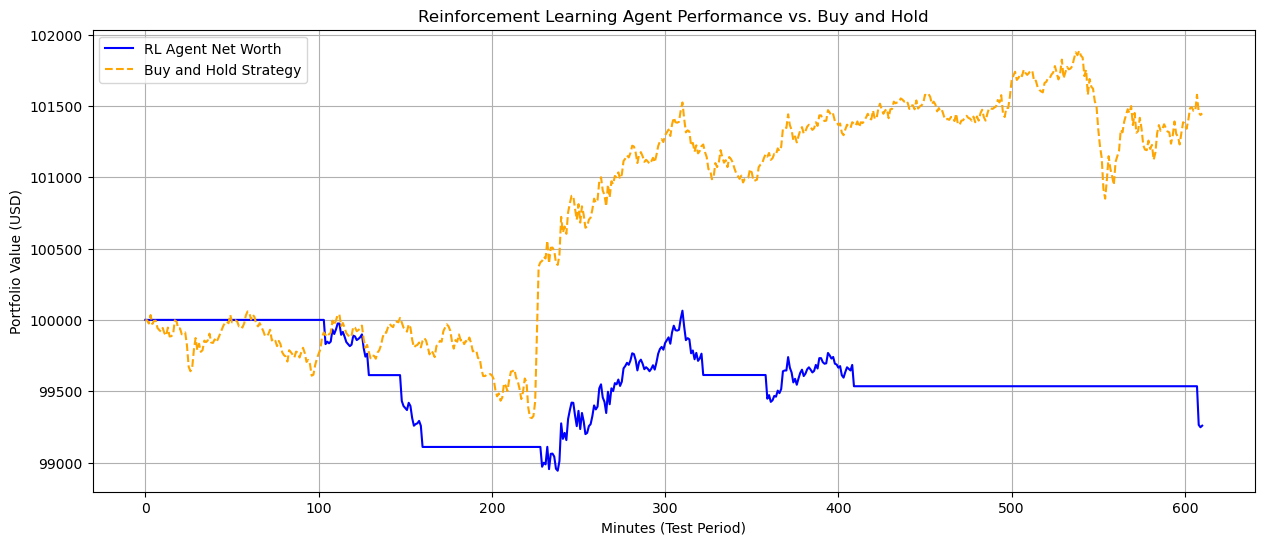

In [76]:
print("\nEvaluating RL Agent on test data...")
test_df_rl = df.iloc[split_index:].copy()
test_df_rl[features] = scaler.transform(test_df_rl[features]) # Scaling test data using the *trained* scaler

eval_env = TradingEnv(test_df_rl, features)
obs, info = eval_env.reset()
done = False
truncated = False # Gymnasium v0.26+ includes 'truncated'

while not done and not truncated:
    action, _states = rl_model.predict(obs, deterministic=True) # Use deterministic policy for evaluation
    obs, reward, done, truncated, info = eval_env.step(action)

print(f"RL Agent final net worth: ${eval_env.net_worth[-1]:.2f}")
print(f"RL Agent total trades (approx): {len(eval_env.history)} (Note: This is a simplified count)")

# Plot results
print("\nPlotting RL Agent performance vs. Buy and Hold...")
plt.figure(figsize=(15, 6))
plt.plot(eval_env.net_worth, label='RL Agent Net Worth', color='blue')
# Calculate Buy and Hold strategy performance for comparison
buy_and_hold_returns = (test_df_rl['Close'] / test_df_rl['Close'].iloc[0]) * eval_env.initial_amount
plt.plot(buy_and_hold_returns.values, label='Buy and Hold Strategy', color='orange', linestyle='--')
plt.title("Reinforcement Learning Agent Performance vs. Buy and Hold")
plt.xlabel("Minutes (Test Period)")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.grid(True)
plt.show()

**Plot results**

## Model Validation Techniques (Walk-Forward Backtest)
This is the most critical part for any trading role. A model that looks good on paper can fail spectacularly if not validated correctly. Never trust a simple train-test split on time series data.

**WHAT?**<br>
- I'm using Walk-Forward Validation, the industry standard for backtesting trading strategies.
- I'll use scikit-learn's `TimeSeriesSplit` to generate the training and testing indices.

**WHY?**<br>
- A simple random split on time series data causes **lookahead bias**.<br>
You might train on data from the future to predict the past, which is impossible in real life and leads to wildly optimistic results.<br>
- Walk-Forward Validation simulates reality:<br>
    - Train on a block of historical data (e.g., weeks 1-4).<br>
    - Test on the immediately following block (e.g., week 5).<br>
    - Slide the window forward: Train on weeks 2-5, test on week 6.<br>
    - Repeat the process.<br>

This ensures the model is always predicting the future with data only from the past.

**EFFECT & RESULT**
- I perform a robust backtest, accumulating predictions from each fold. Then I'll calculate performance metrics on these out-of-sample predictions, giving a much more realistic estimate of the model's true performance.

In [81]:
print("\nStarting Walk-Forward Validation for LightGBM...")

tscv = TimeSeriesSplit(n_splits = 5)
all_lgbm_preds = []
all_true_targets = []
all_log_returns = []

# Using the original X and y DataFrames for indexing
X_full = X_scaled_df # Already scaled
y_full = y

fold_num = 1
for train_index, test_index in tscv.split(X_full):
    print(f"\n--- Walk-Forward Fold {fold_num} ---")
    X_train_fold, X_test_fold = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_fold, y_test_fold = y_full.iloc[train_index], y_full.iloc[test_index]

    # Re-initialization and training the LGBM model for each fold
    fold_lgbm_model = lgb.LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.05, num_leaves=31)
    fold_lgbm_model.fit(X_train_fold, y_train_fold)
    model = lgb.LGBMClassifier(random_state = 42)
    model.fit(X_train_fold, y_train_fold)

    # Prediction on the test fold
    preds = fold_lgbm_model.predict(X_test_fold)

    # Storing predictions and true values
    all_lgbm_preds.extend(preds)
    all_true_targets.extend(y_test_fold.tolist())

    # Storing corresponding log returns for strategy simulation
    all_log_returns.extend(df['log_return'].iloc[test_index].tolist())
    fold_accuracy = accuracy_score(y_test_fold, preds)
    print(f"Fold {fold_num} Accuracy: {fold_accuracy:.4f}")

print("Walk-Forward Validation Complete.")
walk_forward_accuracy = accuracy_score(all_true_targets, all_lgbm_preds)
print(f"Walk-Forward Accuracy (Overall): {walk_forward_accuracy:.4f}\n")
print("Walk-Forward Classification Report (Overall):")
print(classification_report(all_true_targets, all_lgbm_preds))


Starting Walk-Forward Validation for LightGBM...

--- Walk-Forward Fold 1 ---
[LightGBM] [Info] Number of positive: 232, number of negative: 278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2628
[LightGBM] [Info] Number of data points in the train set: 510, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.454902 -> initscore=-0.180884
[LightGBM] [Info] Start training from score -0.180884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

**Result Analysis:**<br>
The walk-forward accuracy is very close to simple split, which is a good sign. In cases of heavy overfitting, this score would be significantly lower.

### Backtesting Metrics Calculation
**WHAT**<br>
Now, it's time to calculate the key backtesting metrics beyond simple accuracy.

**WHY**<br>
- Accuracy is a poor metric for trading. A model could be 99% accurate by always predicting "hold" but would make no money.<br>
- There's a need for metrics that measure profitability and risk.<br>
    - Sharpe Ratio: The holy grail. It measures risk-adjusted return. A Sharpe > 1 is good, > 2 is great.<br>
    - Max Drawdown: The largest percentage drop from a peak. It measures how much pain one would have endured. Lower is better.<br>
    - Calmar Ratio: Annualized return / Max Drawdown. Another measure of risk-adjusted performance.

**EFFECT & RESULT**<br>
This gets and shows a realistic, professional-level assessment of the strategy's performance. These are the numbers that a real HFT firm would care about.


Simulating strategy returns based on walk-forward predictions...

Strategy Performance Metrics:
Annualized Sharpe Ratio: -22.82
Maximum Drawdown: -13.16%
Calmar Ratio: -7.56

Plotting Walk-Forward Backtest - Strategy Performance...


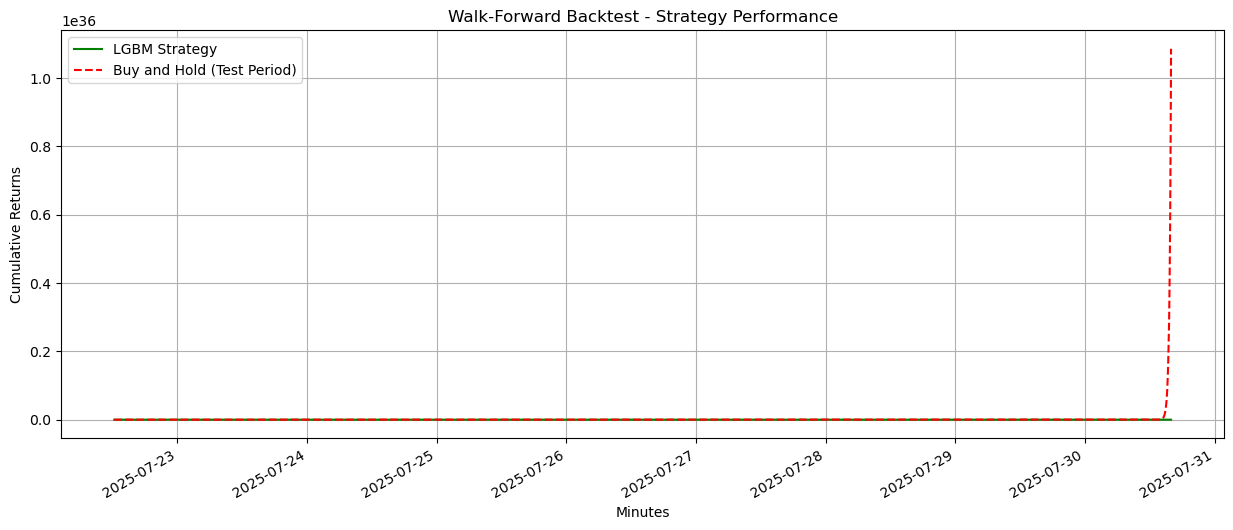

The trained LightGBM model and scaler have been saved to the 'trained_models' directory.
The RL agent has also been trained and saved.


In [85]:
print("\nSimulating strategy returns based on walk-forward predictions...")

strategy_returns = []

if len(all_lgbm_preds) != len(all_log_returns):
    raise ValueError("Length of predictions and log returns do not match for strategy simulation.")
    
for i in range(len(all_lgbm_preds)):
    position = 1 if all_lgbm_preds[i] == 1 else -1 # Simplified: 1 for long, -1 for short
    strategy_returns.append(all_log_returns[i] * position)

strategy_returns = pd.Series(strategy_returns, index=df.index[-len(all_lgbm_preds):])
cumulative_returns = np.exp(strategy_returns.cumsum())
cumulative_returns.iloc[0] = 1.0 # Start cumulative returns at 1.0

print("\nStrategy Performance Metrics:")

# Matrix Calculation
minutes_per_year = 252 * 390 # Approx trading minutes in a year (252 trading days)

if strategy_returns.std() != 0:
    sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(minutes_per_year)
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

# Max Drawdown
rolling_max = cumulative_returns.cummax()
# daily drawdown calculation
daily_drawdown = cumulative_returns / rolling_max - 1.0
# Finding the max drawdown (most negative value)
max_drawdown = daily_drawdown.cummin().iloc[-1]
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Calmar Ratio
# annualized_return = cumulative_returns.iloc[-1]**(1/len(cumulative_returns) * (353 * 390)) - 1
total_minutes_in_backtest = len(cumulative_returns)
if total_minutes_in_backtest > 0:
    annualized_return = (cumulative_returns.iloc[-1]**(minutes_per_year / total_minutes_in_backtest)) - 1
else:
    annualized_return = np.nan

if abs(max_drawdown) != 0:
    calmar_ratio = annualized_return / abs(max_drawdown)
else:
    calmar_ratio = np.nan
print(f"Calmar Ratio: {calmar_ratio:.2f}")

# Plot Walk-Forward Backtest - Strategy Performance
print("\nPlotting Walk-Forward Backtest - Strategy Performance...")
plt.figure(figsize=(15, 6))
cumulative_returns.plot(label='LGBM Strategy', color='green')
# Plotting Buy and Hold performance over the same walk-forward test period
buy_and_hold_walk_forward = (df['Close'].iloc[-len(all_true_targets):] / df['Close'].iloc[-len(all_true_targets)]).cumprod()
buy_and_hold_walk_forward.iloc[0] = 1.0 # Ensure it starts at 1.0 for comparison
buy_and_hold_walk_forward.plot(label='Buy and Hold (Test Period)', color='red', linestyle='--')

plt.title("Walk-Forward Backtest - Strategy Performance")
plt.xlabel("Minutes")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

print("The trained LightGBM model and scaler have been saved to the 'trained_models' directory.")
print("The RL agent has also been trained and saved.")